# Z from RMS (Monte Carlo data)

## This notebook:

- Uses Monte Carlo data.
- Selects events with 1 S1 and 1 S2.
- Uses Zrms (= RMS of the S2 waveform) as an estimator of Z
- Computes the quantity Zrms - Z (where Z is obtained as the difference between S1 and S2)

## Authors: JJGC

### Software: KrCalib : https://github.com/nextic/KrCalib/

### Description:

- Uses Kr83_NEW_v1_04_00_nexus_v5_03_04_ACTIVE_10.2bar_run4 MC production. January 2019. 


In [4]:
import time
print("Last updated on ", time.asctime())

Last updated on  Mon Feb  4 17:43:05 2019


In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [6]:
import os
import time
import datetime 
import numpy as np
import pandas as pd
import tables            as tb
import random
import glob
import seaborn as sns
sns.set()

In [7]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units


In [10]:
from krcal.core.io_functions       import filenames_from_paths
from krcal.core.io_functions       import write_monitor_vars
from krcal.core.io_functions       import kdst_write
from krcal.core.histo_functions    import h1, h1d, h2d, plot_histo

In [121]:
from krcal.core.kr_types           import PlotLabels
from krcal.core.analysis_functions import kr_ranges_and_bins
from krcal.core.analysis_functions import kr_event
from krcal.core.analysis_functions import selection_info
from krcal.core.analysis_functions import selection_in_band
from krcal.core.analysis_functions import plot_selection_in_band
from krcal.core.s1s2_functions     import s1d_from_dst
from krcal.core.s1s2_functions     import s2d_from_dst
from krcal.core.s1s2_functions     import plot_s1histos
from krcal.core.s1s2_functions     import plot_s2histos

In [12]:
from krcal.core.plt_functions      import plot_xy_density
from krcal.core.plt_functions      import plot_s1_vs_z
from krcal.core.plt_functions      import plot_s2_vs_z
from krcal.core.plt_functions      import plot_s2_vs_s1
from krcal.core.plt_functions      import plot_q_vs_s2
from krcal.core.plt_functions      import plot_energy_distributions
from krcal.core.plt_functions      import plot_energy_vs_t


In [13]:
import krcal.dev.corrections       as corrections 
import krcal.utils.hst_extend_functions as hst

In [14]:
from krcal.core.core_functions          import time_delta_from_time
from krcal.core import fit_functions_ic as fitf
from krcal.core.histo_functions import profile1d

### Input/output 

In [19]:
path   = "/Users/jjgomezcadenas/Projects/ICDATA/kdst/mcr4/"
files  = "Kr83_NEW_v1_04_00_nexus_v5_03_04_ACTIVE_10.2bar_run4*.h5"
filenames = "".join([path, files])
input_dst_filenames  = glob.glob(os.path.expandvars(filenames))
output_dst_filename = "".join(['/Users/jjgomezcadenas/Projects/ICDATA/dst/', 'Kr83_NEW_v1_04_00_nexus_v5_03_04_ACTIVE_10.2bar_run4.h5'])


bootstrap_correction_filename   = f"$IC_DATA/maps/kr_corrections_run6206.h5"
write_filtered_dst = True

In [21]:
print(f'input dsts:\n first = {input_dst_filenames[0]}\n last = {input_dst_filenames[-1]}')
print(f'size of input dst = {len(input_dst_filenames)}')
print(f"output dst = {output_dst_filename}")                     

input dsts:
 first = /Users/jjgomezcadenas/Projects/ICDATA/kdst/mcr4/Kr83_NEW_v1_04_00_nexus_v5_03_04_ACTIVE_10.2bar_run4.715_9.h5
 last = /Users/jjgomezcadenas/Projects/ICDATA/kdst/mcr4/Kr83_NEW_v1_04_00_nexus_v5_03_04_ACTIVE_10.2bar_run4.584_6.h5
size of input dst = 10000
output dst = /Users/jjgomezcadenas/Projects/ICDATA/dst/Kr83_NEW_v1_04_00_nexus_v5_03_04_ACTIVE_10.2bar_run4.h5


In [22]:
dst_full           = load_dsts(input_dst_filenames, "DST", "Events")

In [23]:
unique_events = ~dst_full.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 8126428 
Total number of events: 8119730


In [24]:
dst_full.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT', 'Z',
       'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [25]:
ntot = len(dst_full)
print(f"length of dst = {ntot}")

length of dst = 8126428


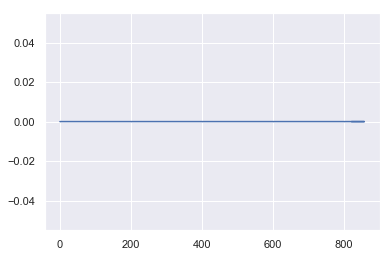

In [27]:
plt.plot(dst_full.time)

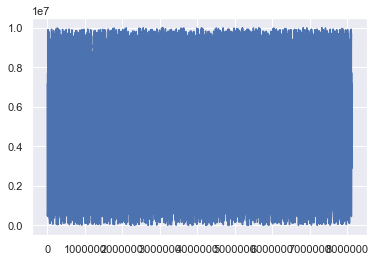

In [30]:
plt.plot(np.arange(len(dst_full)), dst_full.event)

In [31]:
dst_full.head()

,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
0,7159001,0.0,0,0,1,1,125.0,1.214591,6.584613,100100.0,...,17,101.433426,101.433426,0.953486,64.511997,-171.495731,183.228228,-1.210998,7.429624,8.554511
1,7159002,0.0,0,0,1,1,175.0,2.992643,12.735414,100125.0,...,17,532.350403,532.350403,1.975256,-18.735245,55.411606,58.493209,1.896840,9.436013,9.160717
2,7159003,0.0,0,0,1,1,150.0,2.294890,12.482122,100125.0,...,16,219.348267,219.348267,1.318992,-90.395410,-125.695912,154.825038,-2.194266,8.206809,7.859236
3,7159004,0.0,0,0,1,1,200.0,1.668392,11.625099,100100.0,...,16,377.395874,377.395874,1.636949,26.524691,-175.986038,177.973719,-1.421202,28.001449,31.735172
4,7159005,0.0,0,0,1,1,225.0,3.289797,16.186743,100125.0,...,15,424.372467,424.372467,1.759240,27.240713,120.229353,123.276736,1.347985,8.269622,8.951708


In [37]:
t = np.zeros(10)

In [38]:
t

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [41]:
(t==0).all()

True

In [122]:
RMAX      = 200
RFID      = 180
RCORE     = 100
s1e_range = (1, 25)
s2e_range = (1000, 15000)
s2w_range =(4, 15)
s2q_range = (200, 800)
Nsipm_min = 10
xy_range  = (-RMAX,  RMAX)
z_range   = (10,  550)
e_range = (5000, 14000)
lt_range = (1000, 6000)
c2_range = (0,5)

krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst_full,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 100,
                                                        ynbins    = 100,
                                                        znbins    = 50,
                                                        s2enbins  = 50,
                                                        s1enbins  = 50,
                                                        s2qnbins  = 50,
                                                        tpsamples = 3600) # tsamples in seconds

### Time
- Extension in hours of data sample considered

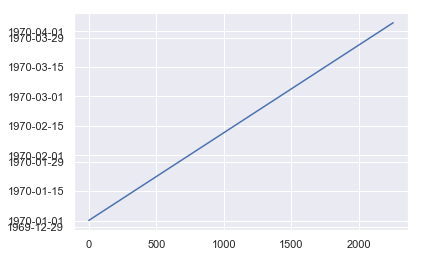

In [123]:
plt.plot(krTimes.timeStamps)

### S1/S2

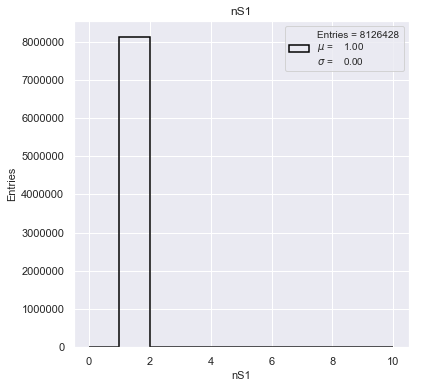

In [50]:
n, b, _, _ = h1d(dst_full.nS1.values, bins = 10, range = (0,10),
           pltLabels=PlotLabels(x='nS1', y='Entries', title='nS1'))

In [51]:
fnS1 = n[n.argmax()]/np.sum(n)
print(f'fraction of S1s = {fnS1}')

fraction of S1s = 1.0


#### Fraction of events with 1 S1 is 0.5. For Krypton select events with 1 S1

### Select events with 1 S1

In [52]:
dst1s1 = dst_full[dst_full.nS1==1]

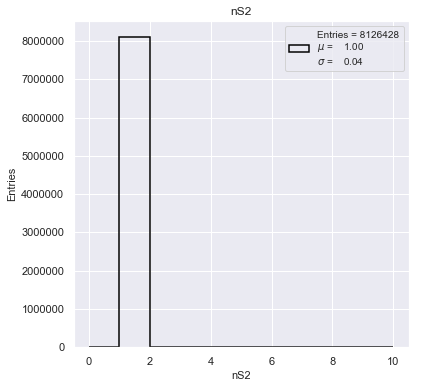

In [53]:
n, b, _, _ = h1d(dst1s1.nS2.values, bins = 10, range = (0,10),
           pltLabels=PlotLabels(x='nS2', y='Entries', title='nS2'))

#### For Krypton select events with only 1 S2

In [54]:
fnS2 = n[n.argmax()]/np.sum(n)
print(f'fraction of S2s = {fnS2}')

fraction of S2s = 0.9983516743149635


### Select events with 1 S2

In [55]:
dst    = dst1s1[dst1s1.nS2==1]

In [56]:
n_full   = len(dst)
eff = n_full   / ntot 
print(f"Total number of events with 1 s1 and 1 s2 : {n_full}: selection eff = {eff} ")

Total number of events with 1 s1 and 1 s2 : 8113033: selection eff = 0.9983516743149635 


### S1 and S2 distributions

In [57]:
s1d = s1d_from_dst(dst)

warning, empty slice of x = [100100. 100125. 100125. ... 100125. 100225. 100150.] in range = (0, 600)
returning mean and std of x = [100100. 100125. 100125. ... 100125. 100225. 100150.]


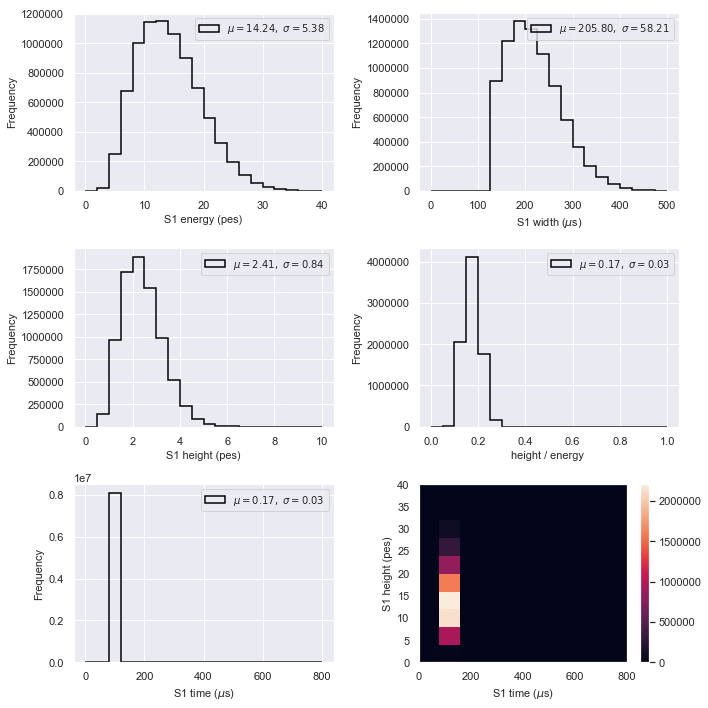

In [58]:
plot_s1histos(dst,  s1d, bins=20, figsize=(10,10))

#### MC production, S1 and S2 in fixed positions.

## Fiducial selection 

In [59]:
dst_s1e    = dst[in_range(dst.S1e, *s1e_range)] 
dst_s2e    = dst_s1e[in_range(dst_s1e.S2e, *s2e_range)] 
dst_s2w    = dst_s2e[in_range(dst_s2e.S2w, *s2w_range)]
dst_sipm   = dst_s2w[dst_s2w.Nsipm > Nsipm_min] 
dst_s2q    = dst_sipm[in_range(dst_sipm.S2q, *s2q_range)]
dst       = dst_s2q

warning, empty slice of x = [100100. 100125. 100125. ... 100125. 100225. 100150.] in range = (0, 600)
returning mean and std of x = [100100. 100125. 100125. ... 100125. 100225. 100150.]


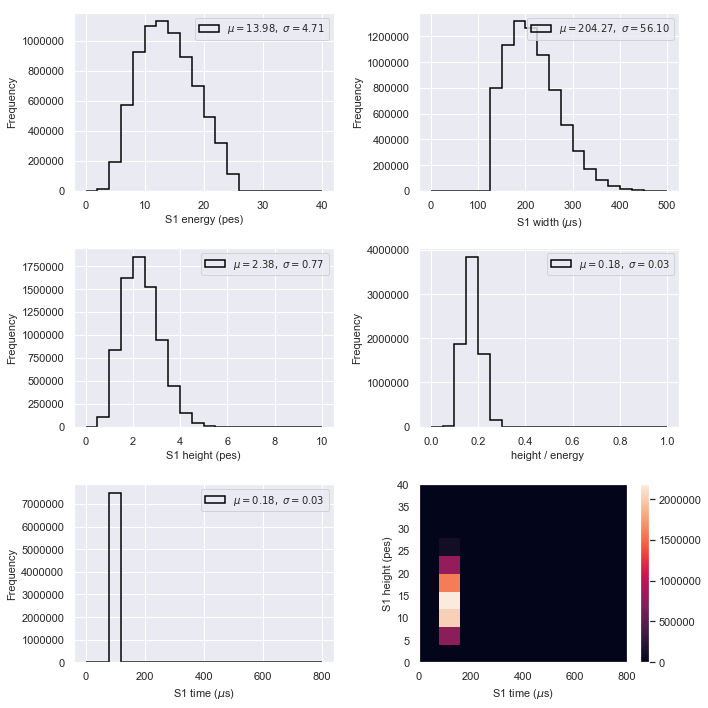

In [60]:
s1d = s1d_from_dst(dst)
plot_s1histos(dst,  s1d, bins=20, figsize=(10,10))

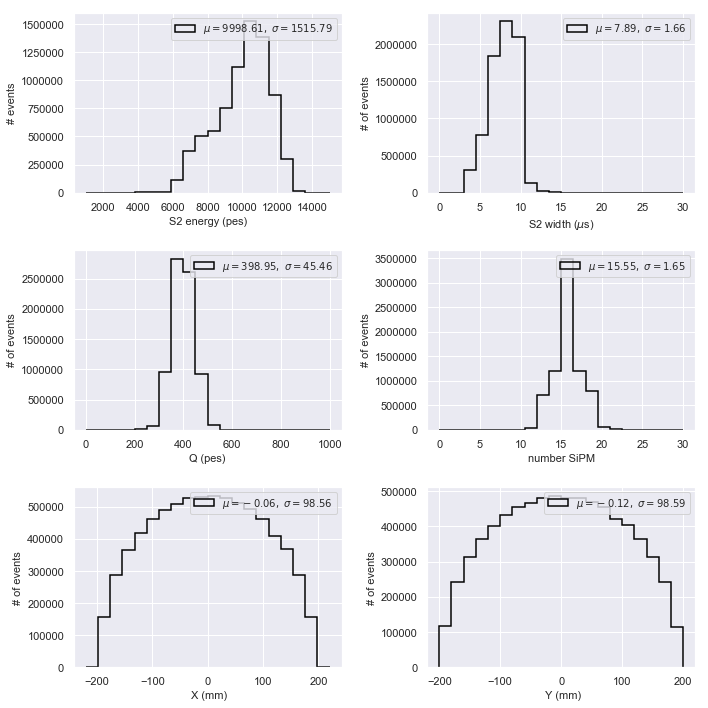

In [61]:
s2d = s2d_from_dst(dst)
plot_s2histos(dst, s2d, bins=20, emin=1000, emax=15000, figsize=(10,10))

### Select fiducial region in R

In [124]:
dstf     = dst[dst.R < RFID]

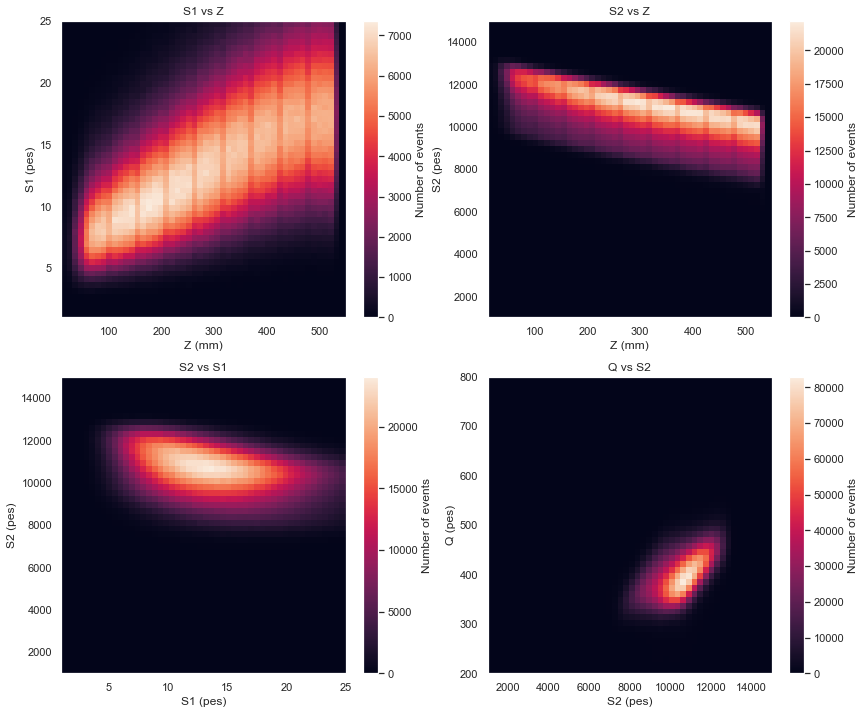

In [125]:
plot_energy_distributions(dstf, krBins.Z, krBins.S1e, krBins.S2e, krBins.S2q, figsize=(14,12))

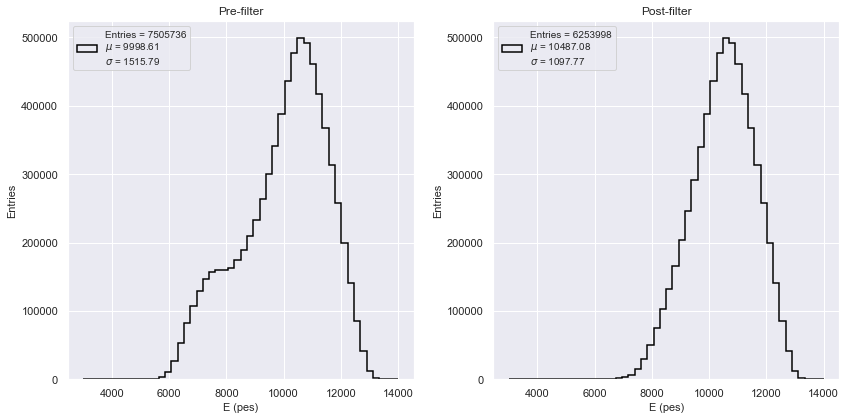

In [127]:
fig = plt.figure(figsize=(12,6))
ax      = fig.add_subplot(1, 2, 1)
(_)     = h1(dst.S2e,  bins = 50, range =(3000,14000))
plot_histo(PlotLabels('E (pes)','Entries','Pre-filter'), ax, legendloc='upper left')
ax      = fig.add_subplot(1, 2, 2)
(_)     = h1(dstf.S2e,  bins = 50, range =(3000,14000))
plot_histo(PlotLabels('E (pes)','Entries','Post-filter'), ax, legendloc='upper left')
plt.tight_layout()

### X vs Y 

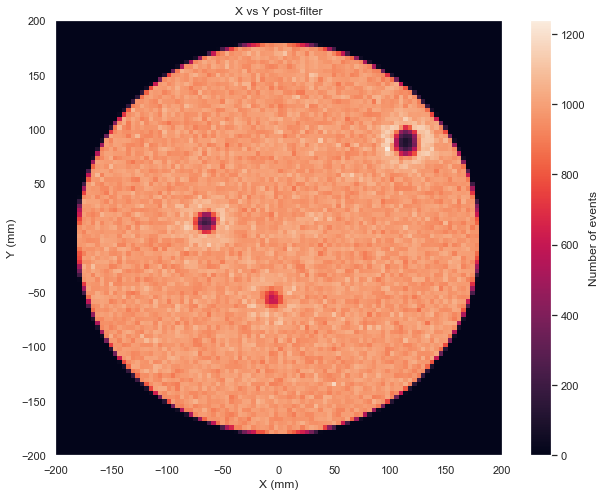

In [91]:
nevt = h2d(dstf.X, dstf.Y, krNbins.X, krNbins.Y, krRanges.X, krRanges.Y, 
           pltLabels=PlotLabels(x='X (mm)', y='Y (mm)', title='X vs Y post-filter'),
           profile=False,
           figsize=(10,8))

## Z vs Zrms (= rms of the S2 waveform)

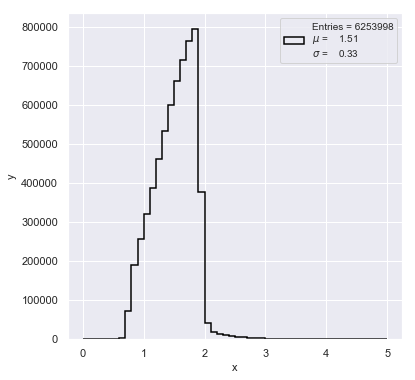

In [92]:
(_) = h1d(dstf.Zrms, bins = 50, range =(0,5))

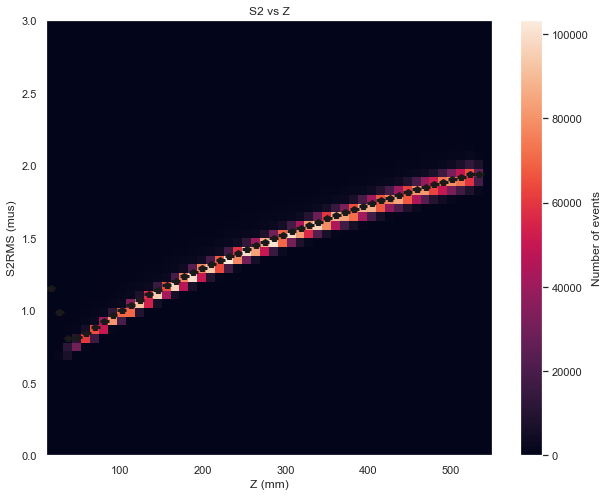

In [93]:
nevt = h2d(dstf.Z, dstf.Zrms, 50, 50, (10,550), (0,3), 
           pltLabels=PlotLabels(x='Z (mm)', y='S2RMS (mus)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

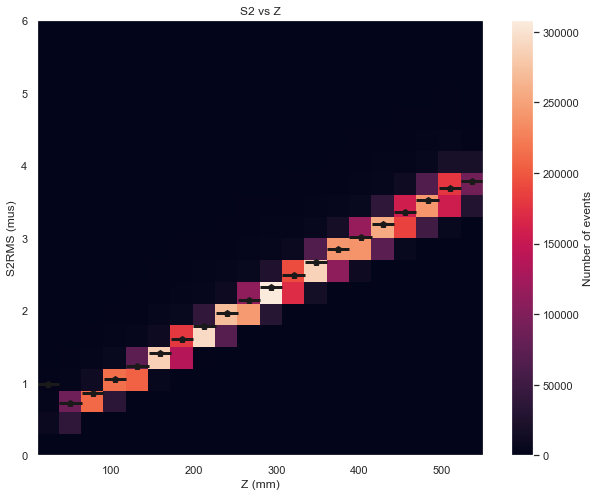

In [94]:
nevt = h2d(dstf.Z, dstf.Zrms * dstf.Zrms, 20, 20, (10,550), (0,6), 
           pltLabels=PlotLabels(x='Z (mm)', y='S2RMS (mus)', title='S2 vs Z'),
           profile=True,
           figsize=(10,8))

In [99]:
x, y, yu  = profile1d(dstf.Z, dstf.Zrms * dstf.Zrms, 20, range_z=(50, 500))

In [111]:
fh     = fitf.fit(fitf.polynom, x, y, seed=(1,1), fit_range=(10,500), sigma=0.005*y)

In [112]:
fh

FitFunction(fn=<function fit.<locals>.<lambda> at 0x1a18973598>, values=array([0.35801024, 0.00664305]), errors=array([3.19113526e-03, 1.64748140e-05]), chi2=1.2360579643418255, pvalue=0.22111587465287977, cov=array([[ 1.01833443e-05, -4.35840635e-08],
       [-4.35840635e-08,  2.71419496e-10]]))

Text(0, 0.5, 'Zrms2')

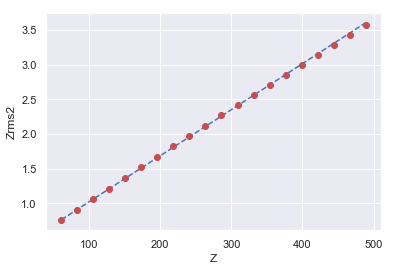

In [113]:
plt.errorbar(x, y,  yerr=0.01*y, fmt='ro')
plt.plot(x, fh.fn(x), 'b--')
plt.xlabel('Z')
plt.ylabel('Zrms2')

In [114]:
def z_from_s2rms(s2rms : np.array,  fh)->np.array:
    zr = (s2rms * s2rms - fh.values[0]) / fh.values[1]
    return zr 

In [115]:
zs2w = z_from_s2rms(dstf.Zrms, fh)

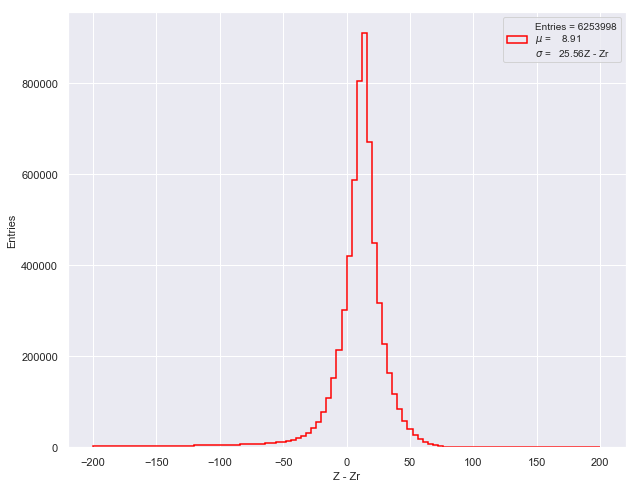

In [116]:
fig = plt.figure(figsize=(10,8))
ax      = fig.add_subplot(1, 1, 1)
(_)    = h1(dstf.Z - zs2w, bins=100, range = (-200,200), color='red', stats=True, lbl='Z - Zr')
plot_histo(PlotLabels('Z - Zr','Entries',''), ax)

In [117]:
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from krcal.core.fit_energy_functions       import gaussian_parameters
from krcal.core.fit_energy_functions       import gaussian_fit

In [118]:
rng     = (-50,50)
nbins   = 25
n_sigma = 3
y, b = np.histogram(dstf.Z - zs2w, bins= nbins, range=rng)
x = shift_to_bin_centers(b)
bin_size = (rng[1] - rng[0]) / nbins
seed = gaussian_parameters(dstf.Z - zs2w, rng, bin_size)


In [119]:
fp, fr = gaussian_fit(x, y, seed, n_sigma)

FitResult(par=array([2.21283701e+07, 1.23385760e+01, 1.35456352e+01]), err=array([9.42488273e+03, 5.84659326e-03, 5.12136826e-03]), chi2=121.40541155641914, valid=True)

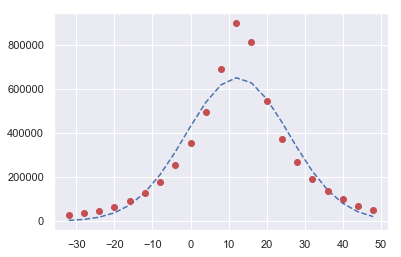

In [120]:
plt.errorbar(fp.x, fp.y,  yerr=fp.yu, fmt='ro')
plt.plot(fp.x, fp.f(fp.x), 'b--')
fr

## Outlook:

- This is Monte Carlo data, no bias or mistakes in selection. 
- For this sample Zrms and Z can be fitted to a straight line and an estimator of Z (Zr) can be obtained.
- The distribution (Z - Zr) is non gaussian and has long tails, in particular to the left side of the distribution, **just like the data** 
- The rms of the distribution is large (~25 mm), **just like the data**

#### The non-gaussian tails and large rms are a certain source of systematics is Zrms is used as an estimator of Z. The MC study shows that the bias and the tails are intrinsic to the method, and not related to reconstruction systematics (or at least with reconstruction systematics not present in the MC).  

## End of NB